<a href="https://colab.research.google.com/github/hukongyi/d2l_Colab/blob/main/08_linear_regression/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l > /dev/null
!pip install matplotlib > /dev/null
!pip install matplotlib_inline > /dev/null

# 线性回归的从零实现

In [2]:
import torch
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
torch.__version__

'1.12.1+cu113'

In [4]:
def synthetic_data(w, b, num_examples):
    x = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(x, w)+b
    y += torch.normal(0, 0.01, y.shape)
    return x, y.reshape(-1, 1)


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

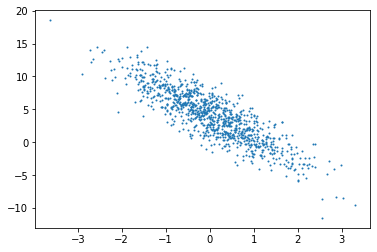

In [5]:
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indice = torch.tensor(
            indices[i: min(i+batch_size, num_examples)])
        yield features[batch_indice], labels[batch_indice]


batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.7463, -0.4519],
        [ 0.6155,  0.3076],
        [-0.2243,  0.3889],
        [ 0.3196,  0.8492],
        [ 0.6757,  1.8440],
        [ 0.8298,  1.8054],
        [ 1.0324,  0.1608],
        [ 0.1079,  0.5869],
        [-0.0562,  0.8911],
        [ 1.8345, -0.3553]]) 
 tensor([[ 7.2218],
        [ 4.3878],
        [ 2.4412],
        [ 1.9515],
        [-0.7237],
        [-0.2711],
        [ 5.7144],
        [ 2.4363],
        [ 1.0603],
        [ 9.0756]])


In [7]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [8]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [9]:
def squared_loss(y_hat, y):
    return (y_hat-y.reshape(y_hat.shape))**2/2

In [10]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [11]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):0.5f}')

epoch 1, loss 0.03991
epoch 2, loss 0.00015
epoch 3, loss 0.00005


In [12]:
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b-b}')

w的估计误差：tensor([-2.1601e-04, -1.9312e-05], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0007], grad_fn=<RsubBackward1>)


# 线性回归的简洁实现

In [13]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [14]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [15]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [16]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[ 1.0625, -0.8409],
         [-1.2559,  1.3893],
         [-0.0883, -1.1716],
         [-0.9658, -0.6640],
         [ 1.4655,  0.6771],
         [-0.4121,  1.4107],
         [ 1.0817, -0.7868],
         [-0.2314,  1.1123],
         [ 0.4243,  0.7578],
         [-0.5829,  0.7024]]), tensor([[ 9.1881],
         [-3.0486],
         [ 8.0283],
         [ 4.5442],
         [ 4.8276],
         [-1.4290],
         [ 9.0324],
         [-0.0364],
         [ 2.4676],
         [ 0.6414]])]

In [17]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [18]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [19]:
loss = nn.MSELoss()

In [20]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [21]:
num_epochs = 3
for epoch in range(num_epochs):
    for X,y in data_iter:
        l = loss(net(X),y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features),labels)
    print(f'epoch {epoch+1}, loss {l:0.5f}')

epoch 1, loss 0.00022
epoch 2, loss 0.00010
epoch 3, loss 0.00010
